In [1]:
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns

*** TASK 1 ***

In [49]:
### HW2 TASK 1 ###

# This function takes in a pandas dataframe and a list of indices or 
# column names to one hot encode. It returns a numpy matrix representing the 
# data table with all relevant columns one hot encoded
def PandasOneHotEncodeNumpy(DataFrame, Columns): 
    df = DataFrame.copy() #create a copy to preserve original df

    column_names = []
    # loop through provided columns and convert indices to column names for use
    for i in Columns: 
        if (isinstance(i, int)): 
            column_names.append(df.columns[i])
        else: 
            column_names.append(i)

    # loop through all columns 
    for col in column_names: 
        # get all categories within the column 
        values = df[col].unique().tolist()

        # for all but the first category (ie. drop the first category)
        for val in values[1:]:
            new_col_name = f"{col}_{val}" #create new name

            # create a new column with the new title. Then we must assign each sample 
            # a value in this column. If the original categorical column's value for the sample is 
            # equal to the category we are building a column for this comparison will return
            # true, converted to 1, otherwise it will return false, converted to 0. 
            df[new_col_name] = (df[col] == val).astype(np.float32)
        
        df = df.drop(columns = [col]) #drop the original categorical column
    
    all_column_names = df.columns.tolist()

    #convert df to matrix and return 
    numpy_mat = df.to_numpy(dtype=np.float32)
    return numpy_mat, all_column_names

In [50]:
# Reading in data
train_df_ori = pd.read_csv('train.csv')
test_df_ori = pd.read_csv('test.csv')

# Saving passenger id's for kaggle submission
passenger_ids = test_df_ori["PassengerId"]

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()


In [51]:
# BEGINNING PREPROCESSING - This preprocessing pipeline is heavily inspired by 
# the example code from the lecture 5 jupyter notebook. 

# Dropping unimportant and poor features. These features are either
# irrelevant to survival or in difficult to manage formats
irrelevant_feats = ['PassengerId', 'Name', 'Cabin', 'Ticket'] 
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

In [52]:
# Imputing - This step will fill in blank or missing values in the dataset

numerical_feats = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_feats = ["Sex", "Embarked"]

# We will replace missing numerical values with the median for that feature
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# We will replace missing categorical values with the mode for that feature 
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# For every column other than "Survived", search for missing values
# and replace them using the corresponding imputer 
for column in train_df.columns[1:]: 
    if (column in numerical_feats): 
        fill = num_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = num_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()
    else: 
        fill = cat_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = cat_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()



In [53]:
train_matrix, train_col = PandasOneHotEncodeNumpy(train_df, categorical_feats)
test_matrix, test_col = PandasOneHotEncodeNumpy(test_df, categorical_feats)

new_train_df = pd.DataFrame(train_matrix, columns=train_col)
new_test_df = pd.DataFrame(test_matrix, columns=test_col)


In [54]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

In [55]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=new_train_df, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=new_test_df, fit_transform=False)

In [56]:
rng1 = np.random.RandomState(seed=45) # seeding our rng

y = train_df2['Survived'].values # extracting targets
#X = train_df2.iloc[:,1:].values # extracting parameters 
X = train_df2.drop(columns=['Survived']).values

# splitting data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)

# ENDING PREPROCESSING - Data is now ready for model training


In [31]:
# SKLEARN MODEL

log_classifier = LogisticRegression(max_iter=1000, random_state=rng1, penalty='l2')
log_classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,RandomState(M... 0x1FD3E3F9440
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [32]:
# Predictions from SKlearn model
y_val_pred = log_classifier.predict(X_val)
y_val_probs = log_classifier.predict_proba(X_val)[:, 1]  # probability of "Survived" 

# Metrics
acc = accuracy_score(y_val, y_val_pred)
loss = log_loss(y_val, y_val_probs)
cm = confusion_matrix(y_val, y_val_pred)

print("Validation Accuracy:", acc)
print("Validation Log Loss (Binary Cross Entropy):", loss)
print("Confusion Matrix:\n", cm)


Validation Accuracy: 0.7985074626865671
Validation Log Loss (Binary Cross Entropy): 0.439815145663617
Confusion Matrix:
 [[75  8]
 [19 32]]


*** Task 2 *** 

In [33]:
### HW 2 TASK 2 ###

# TRAINING AND INTERNAL FUNCTIONS 

# Computes the sigmoid function
def sigmoid(z): 
    return (1 / (1 + np.exp(-z)))

# Initializes the starting parameters w and b with an optional seed 
def initialize_params(m_features, seed=None): 
    if (seed is not None):
        np.random.seed(seed)
    
    w = np.random.rand(m_features, 1)
    b = 0

    # returns parameters 
    return w, b

# Computes the linear combination of featurs and uses the sigmoid
# to calculate probabilities of survival
def forward(X, w, b): 
    z = X.dot(w) + b
    y_hat = sigmoid(z)

    # returns raw score prediction and normalized [0,1] prediction
    return z, y_hat

# Uses binary cross entropy to calculate the log-loss of the training
def compute_cost(y, y_hat, w, reg, lambda_):
    #Force shapes
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Assumes LogLoss
    eps = 1e-12
    cost = -(np.dot(y.T,np.log(y_hat+eps)) + np.dot(1-y.T,np.log(1-y_hat+eps))) / len(y)

    # make cost a scalar 
    cost = np.squeeze(cost)

    if reg is not None and lambda_ > 0.0: 
        if reg == 'L1':
            reg_term = (lambda_/len(y)) * np.sum(np.abs(w))
            cost += reg_term
        elif reg == 'L2': 
            reg_term = (lambda_/(2 * len(y))) * np.sum(np.square(w))
            cost += reg_term

    return cost

# Computes gradients for our gradient descent algorithm 
def compute_gradients(X, y, y_hat, w, reg, lambda_): 
    #Force shapes
    y_hat = y_hat.reshape(-1,1)
    y = y.reshape(-1,1)

    # number of samples
    n = len(y)

    # finding gradients of b and w respectively 
    db = (1/n)*np.sum(y_hat-y)
    dw = (1/n)*X.T.dot(y_hat-y)

    if reg is not None and lambda_ > 0.0: 
        if reg == 'L1': 
            dw += (lambda_ / n) * np.sign(w)
        elif reg == 'L2': 
            dw += (lambda_ / n) * w

    # returns our gradients for w and b
    return dw, db

# Updates parameters using calculated gradients and provided learning rate 
def update_params(w, b, dw, db, lr): 
    w = w - lr * dw
    b = b - lr * db

    # returns updated w and b params 
    return w, b

# Core training loop 
def train(X, y, lr, n_epochs, reg, lambda_, X_val=None, y_val=None, seed=None): 
    # initialize our parameters 
    samples, features = X.shape
    w, b = initialize_params(features, seed)

    # Initialize two lists to track loss across epochs 
    train_losses = []
    val_losses = []
    
    # For each training iteration
    for i in range(n_epochs): 
        z, y_hat = forward(X, w, b) # Make one forward pass
        cost = compute_cost(y, y_hat, w, reg, lambda_) # Calculate error
        train_losses.append(cost) # Track error
        dw, db = compute_gradients(X, y, y_hat, w, reg, lambda_) # Perform gradient descent 
        w, b = update_params(w, b, dw, db, lr) # Update our parameters 

        # If we have a provided validation set
        if (X_val is not None and y_val is not None): 
            z_val, y_hat_val = forward(X_val, w, b) # Perform one forward pass
            # Calculate and track error on validation set
            val_cost = compute_cost(y_val, y_hat_val, w, reg, lambda_) 
            val_losses.append(val_cost)
    
    # Return our trained parameters and our loss history 
    return w, b, train_losses, val_losses


# PREDICTION FUNCTIONS - USE AFTER TRAINING 

# Calculate probability of survival for a sample 
# EXPECTS TRAINED PARAMETERS
def predict_prob(X, w, b): 
    z, y_hat = forward(X, w, b)

    # returns probability of survival 
    return y_hat

# Predict wether a sample survived, returns a binary int (1 for lived, 0 for died)
# EXPECTS TRAINED PARAMETERS
def predict(X, w, b): 
    prob = predict_prob(X, w, b)
    
    # return boolean for survival as an integer 
    return (prob >= 0.5).astype(int)



In [36]:
# Training and validating scratch model 
w, b, training_loss, val_loss = train(X_train, y_train, .0275, 1500, None, 0.00, X_val, y_val) #no reg
w1, b1, training_loss1, val_loss1 = train(X_train, y_train, .0275, 1500, 'L1', 0.1, X_val, y_val) #l1 reg
w2, b2, training_loss2, val_loss2 = train(X_train, y_train, .0275, 1500, 'L2',0.1, X_val, y_val) #l2 reg

# no reg
y_val_prob = predict_prob(X_val, w, b)
y_val_prediction = predict(X_val, w, b)

# l1 reg
y_val_prob_1 = predict_prob(X_val, w1, b1)
y_val_prediction_1 = predict(X_val, w1, b1)

# l2 reg
y_val_prob_2 = predict_prob(X_val, w2, b2)
y_val_prediction_2 = predict(X_val, w2, b2)

print("NO REG:")
print("Val accuracy:", accuracy_score(y_val, y_val_prediction))
print("Val log loss:", log_loss(y_val, y_val_prob))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_prediction))

print("L1 REG:")
print("Val accuracy:", accuracy_score(y_val, y_val_prediction_1))
print("Val log loss:", log_loss(y_val, y_val_prob_1))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_prediction_1))

print("L2 REG:")
print("Val accuracy:", accuracy_score(y_val, y_val_prediction_2))
print("Val log loss:", log_loss(y_val, y_val_prob_2))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_prediction_2))

NO REG:
Val accuracy: 0.7985074626865671
Val log loss: 0.46077996222025364
Confusion matrix:
 [[76  7]
 [20 31]]
L1 REG:
Val accuracy: 0.7985074626865671
Val log loss: 0.4591369858118196
Confusion matrix:
 [[76  7]
 [20 31]]
L2 REG:
Val accuracy: 0.8134328358208955
Val log loss: 0.45746401563144584
Confusion matrix:
 [[78  5]
 [20 31]]


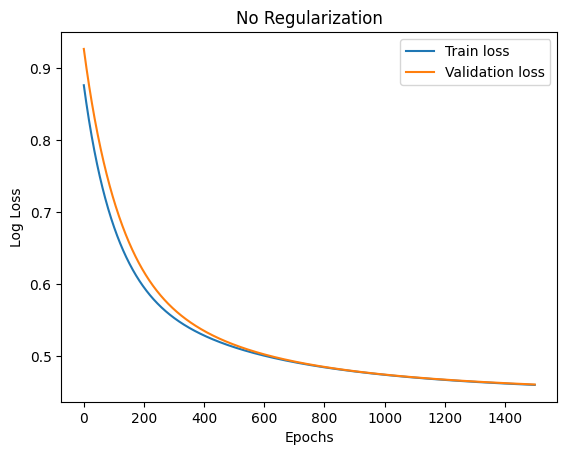

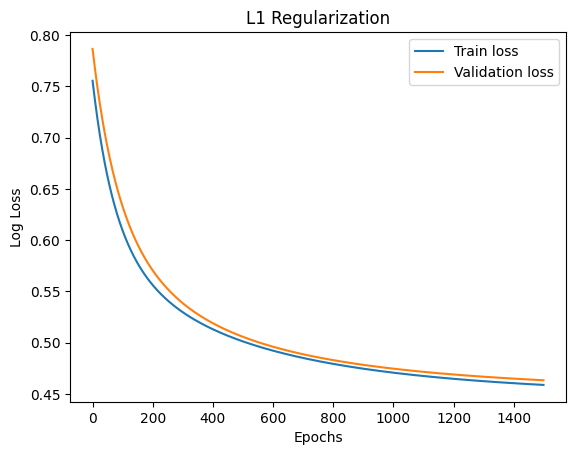

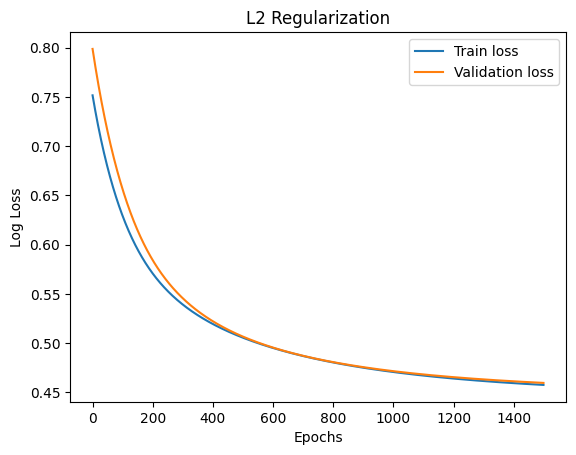

In [37]:
# Plotting loss over epochs 
import matplotlib.pyplot as plt

#None
plt.title("No Regularization")
plt.plot(training_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

#L1
plt.title("L1 Regularization")
plt.plot(training_loss1, label='Train loss')
plt.plot(val_loss1, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

#L2
plt.title("L2 Regularization")
plt.plot(training_loss2, label='Train loss')
plt.plot(val_loss2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [38]:
# TESTING

# SCRATCH TESTING
X_test = test_df2.values
y_test_pred_scratch = predict(X_test, w2, b2).flatten()

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_scratch.astype(int)
})

# Save file
submission.to_csv("l2_reg_submission.csv", index=False)

*** TASK 3 ***

In [39]:
### HW2 TASK 3 ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [40]:
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# param_distributions contains all of the options for each parameter we will experiment with 
param_distributions = {
    'model__n_estimators': [10, 50, 100, 200, 400, 800],
    'model__max_depth': [None, 5, 10, 20, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}


In [41]:
# randomized search will allow us to try all permutations of these parameters 
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,              # number of random combinations to try
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

# saving the best performing model for future use 
best_rf = search.best_estimator_

print("Best parameters:", search.best_params_)
print("Best cross-validation accuracy:", search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 10, 'model__bootstrap': True}
Best cross-validation accuracy: 0.8348379226211223


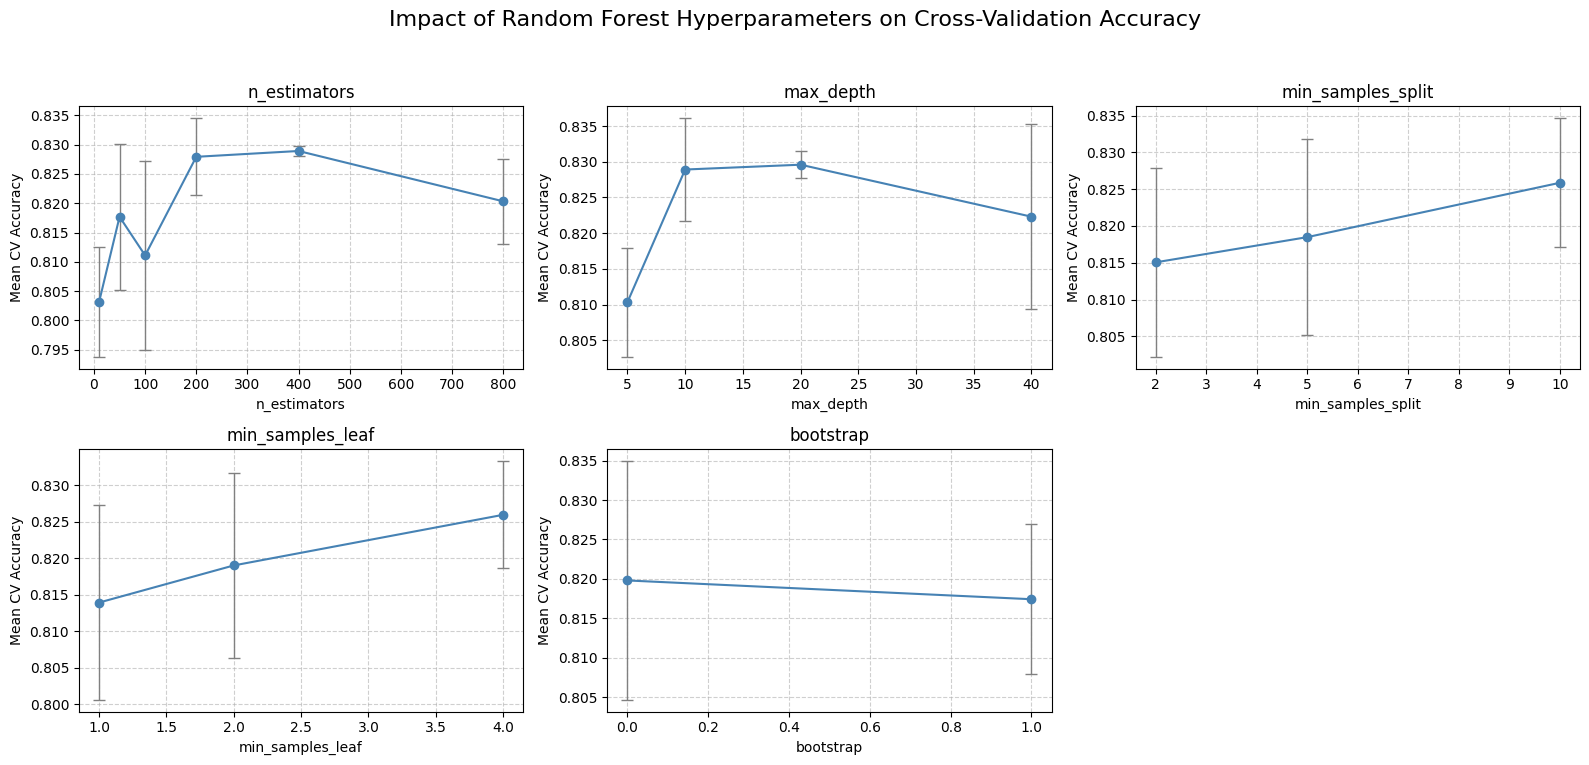

In [42]:
# Convert search results to a DataFrame
results_df = pd.DataFrame(search.cv_results_)

# List of parameters to analyze
params = [
    'param_model__n_estimators',
    'param_model__max_depth',
    'param_model__min_samples_split',
    'param_model__min_samples_leaf',
    'param_model__bootstrap'
]

# Create a multi-panel plot grid
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# Plot mean ± std for each hyperparameter
for i, param in enumerate(params):
    # Aggregate mean and std across other parameters
    summary = results_df.groupby(param)['mean_test_score'].agg(['mean', 'std']).reset_index()
    
    # Handle boolean params (like bootstrap) nicely for plotting
    x = summary[param]
    y = summary['mean']
    yerr = summary['std']

    axes[i].errorbar(
        x, y, yerr=yerr, fmt='o-', capsize=4, elinewidth=1, markersize=6,
        color='steelblue', ecolor='gray'
    )
    axes[i].set_title(param.replace('param_model__', ''), fontsize=12)
    axes[i].set_xlabel(param.split('__')[-1], fontsize=10)
    axes[i].set_ylabel('Mean CV Accuracy', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplot (since we have 5 plots, 6 grid slots)
if len(params) < len(axes):
    for j in range(len(params), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle("Impact of Random Forest Hyperparameters on Cross-Validation Accuracy", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [43]:
n_estimators_list = [10, 50, 100, 200, 400, 800] # size of random forest 
train_accuracies = []
val_accuracies = []

# for each different size use the best parameters found through random search, 
# this will show us which size model is the best performing 
for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=search.best_params_['model__max_depth'],
        min_samples_split=search.best_params_['model__min_samples_split'],
        min_samples_leaf=search.best_params_['model__min_samples_leaf'],
        bootstrap=search.best_params_['model__bootstrap'],
        random_state=42
    )
    rf.fit(X_train, y_train)

    # track results for each size model for generating graph 
    train_accuracies.append(rf.score(X_train, y_train))
    val_accuracies.append(rf.score(X_val, y_val))


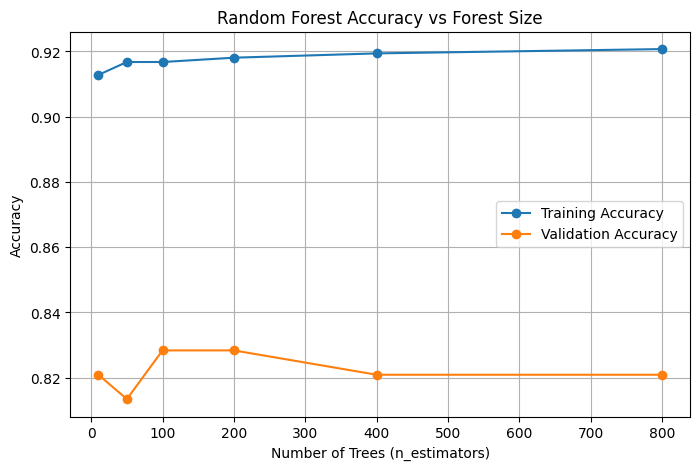

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_estimators_list, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Forest Size")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# TESTING

# RF TESTING
X_test = test_df2.values
y_test_pred_rf = best_rf.predict(X_test)

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_scratch.astype(int)
})

# Save file
submission.to_csv("best_rf_submission.csv", index=False)

*** TASK 4 ***

In [58]:
from sklearn.model_selection import cross_validate, KFold

In [59]:
cv = KFold(n_splits=10)

rf_results = cross_validate(
    best_rf, X, y, 
    cv=cv, 
    scoring='accuracy', 
    return_train_score=True
)

lr_results = cross_validate(
    log_classifier, X, y, 
    cv=cv, 
    scoring='accuracy', 
    return_train_score=True
)

In [60]:
def summarize_cv_results(results):
    scores = results['test_score']
    mean = np.mean(scores) # mean
    std = np.std(scores, ddof=1) # standard deviation
    n = len(scores)
    ci = 1.96 * std / np.sqrt(n) # z * std/root(n)
    return mean, std, ci

rf_mean, rf_std, rf_ci = summarize_cv_results(rf_results)
lr_mean, lr_std, lr_ci = summarize_cv_results(lr_results)

print(f"Random Forest: Mean={rf_mean}, Std={rf_std}, 95% CI=±{rf_ci}")
print(f"Logistic Regression: Mean={lr_mean}, Std={lr_std}, 95% CI=±{lr_ci}")


Random Forest: Mean=0.8373283395755304, Std=0.04588588208476937, 95% CI=±0.028440364367422175
Logistic Regression: Mean=0.7935081148564296, Std=0.03172117345949013, 95% CI=±0.01966098700431326


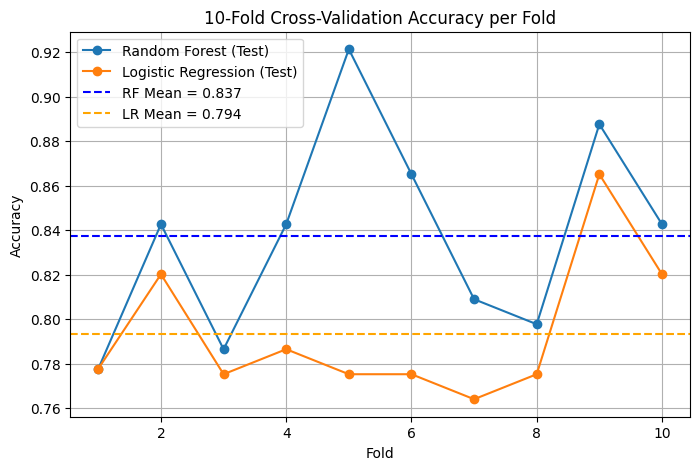

In [61]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), rf_results['test_score'], marker='o', label='Random Forest (Test)')
plt.plot(range(1, 11), lr_results['test_score'], marker='o', label='Logistic Regression (Test)')
plt.axhline(rf_mean, color='blue', linestyle='--', label=f'RF Mean = {rf_mean:.3f}')
plt.axhline(lr_mean, color='orange', linestyle='--', label=f'LR Mean = {lr_mean:.3f}')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("10-Fold Cross-Validation Accuracy per Fold")
plt.legend()
plt.grid(True)
plt.show()
